In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

input_dir = r'''trainset_python\python'''
test_dir = r'''testset_python\python'''
file_list = glob.glob(input_dir + r'''\**\*.npy''' , recursive=True)
test_list = glob.glob(test_dir + r'''\*.npy''' , recursive=True)
label_list =[]
data_list = []

data = np.array([])
for file in file_list :
    if '.labels' in file :
        label_list.append(file)
    elif '.npy' in file: 
        data_list.append(file)

# load features list
for file in data_list:
    if data.shape[0] == 0:
        data = np.load(file)
    else:
        file_data = np.load(file)
        data = np.vstack([data,file_data])
        
#load test data 
# load features list
test_data = np.array([])
for file in test_list:
    if test_data.shape[0] == 0:
        test_data = np.load(file)
    else:
        file_data = np.load(file)
        test_data = np.vstack([test_data,file_data])
        
from scipy import stats as st
#load label list
label_data = np.array([])
for file in label_list:
        file_data = np.load(file).T
        mode_label,_ = st.mode(file_data)
        label_data = np.append(label_data,mode_label)
        
print(label_data.shape)
#data_label = np.load(r'''trainset_python\python\comcuc\25627.labels.npy''')
print (data.shape)
print(test_data.shape)
#print(data_label.shape)
print(len(label_list))
print(len(data_list))
print(len(test_list))

C:\Users\moham\AppData\Local\Temp\ipykernel_34852\4190957077.py:45: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_label,_ = st.mode(file_data)


(120000,)
(120000, 548)
(48000, 548)
1200
1200
16


In [2]:
# count occurrences of each label
label_for_wights = label_data.reshape((-1,100))
max_label  = np.array(label_for_wights)
max_label = np.max(label_for_wights,axis = 1)
#print(max_label.shape)
occ = np.array([np.count_nonzero(label_data == i) for i in range(7)])
occ_sum = np.sum(occ)
wight_singel_points = occ_sum/occ
print(occ)
print(wight_singel_points)
occ = np.array([np.count_nonzero(max_label == i) for i in range(7)])
occ_sum = np.sum(occ)
wight = occ_sum/occ
print(occ)
print(wight)

[85358  5833  8954  8198  2324  5111  4222]
[ 1.40584362 20.57260415 13.40183158 14.63771652 51.63511188 23.47877128
 28.42254856]
[ 30 196 190 195 195 197 197]
[40.          6.12244898  6.31578947  6.15384615  6.15384615  6.09137056
  6.09137056]


Data preprosising

In [3]:
import re
with open(input_dir+r'\feature_names.txt') as my_file:
    feature_text = my_file.read() 
    feature_text = feature_text.splitlines()
    #print(feature_text)
    #extract raw std
    regex = re.compile(r'raw_(.*)_std_(.*)')
    raw_std = [regex.search(feature).group() for feature in feature_text if regex.search(feature)!= None ]
    #print (raw_std)
    #print(len(raw_std))
    
data_mel = data[:,:]
test_mel = test_data[:,:]
#data_label = data_label[:,1]
print(data_mel.shape)

df_test = pd.DataFrame(test_mel, columns = feature_text)
df = pd.DataFrame(data_mel, columns = feature_text)
df['label'] = label_data
df = df.drop(columns=['zcr_mean'
                 ,'raw_bandwidth_mean'
                 ,'raw_energy_mean'
                 ,'raw_power_mean'
                 ,'cln_power_mean'
                 ,'cln_energy_mean'])

df_test = df_test.drop(columns=['zcr_mean'
                 ,'raw_bandwidth_mean'
                 ,'raw_energy_mean'
                 ,'raw_power_mean'
                 ,'cln_power_mean'
                 ,'cln_energy_mean'])

df = df.drop(columns=raw_std)
df_test = df_test.drop(columns=raw_std)

print(df.shape)
print(df_test.shape)

final_data = df.to_numpy()
final_data = final_data.astype('float32')
final_data_test = df_test.to_numpy()
final_data_test = final_data_test.astype('float32')

final_data_reshaped = np.reshape(final_data,(1200,-1,416))
#label_data_reshaped = np.reshape(label_data,(1200,-1)) 
final_data_reshaped = np.reshape(final_data,(1200,1,100,416))

final_data_reshaped_test = np.reshape(final_data_test,(48000,-1,415))
#label_data_reshaped = np.reshape(label_data,(1200,-1)) 
final_data_reshaped_test = np.reshape(final_data_test,(16,3000,415))
final_data_reshaped_test = np.reshape(final_data_reshaped_test,(16,30,100,415))
print(final_data_reshaped.shape)
print(final_data_reshaped_test.shape)
    
    
    

(120000, 548)
(120000, 416)
(48000, 415)
(1200, 1, 100, 416)
(16, 30, 100, 415)


In [5]:
import torch
def count_parameters(model: torch.nn.Module, only_trainable: bool = True) -> int:
    """
    Count (trainable) paramaters of specified model.
    
    :param model: model for which to compute the amount of (trainable) parameters
    :param only_trainable: only include trainable parameters in total count
    :return: amount of (trainable) parameters of the specified model
    """
    return sum(parameter.numel() for parameter in model.parameters() if any(
        (not only_trainable, only_trainable and parameter.requires_grad)))

In [6]:
def save_array_to_csv(array, array_name, file_name):
    if not os.path.exists(file_name):
        with open(file_name, 'w') as file:
            file.write(array_name + ',' + ','.join(map(str, array)) +'\n') 
    else:
        with open(file_name, 'a') as file:
            file.write(array_name + ',' + ','.join(map(str, array)) + '\n')
    return True

Data batching

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.cuda.is_available())
device = torch.device("cuda" )

#split to train / validate

# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
print(final_data_reshaped.shape)
numTrainSamples = int(len(final_data_reshaped) * TRAIN_SPLIT)
numValSamples = int(len(final_data_reshaped) * VAL_SPLIT)
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
(trainData, valData) = torch.utils.data.random_split(final_data_reshaped,[numTrainSamples, numValSamples],generator=torch.Generator().manual_seed(42))

INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10

#trainData    = torch.utils.data.TensorDataset(torch.tensor(trainData).to(device), torch.tensor(trainData).to(device))
#valData    = torch.utils.data.TensorDataset(torch.tensor(valData).to(device), torch.tensor(valData).to(device))


trainDataLoader = torch.utils.data.DataLoader(trainData, shuffle=True,batch_size=BATCH_SIZE)
valDataLoader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE


True
(1200, 1, 100, 416)


In [8]:
def eval_fun(preds,target_i):
    tp = torch.sum(torch.eq(preds,1) & torch.eq(target_i,1),dim = 0)
    tn = torch.sum(torch.eq(preds,0) & torch.eq(target_i,0),dim = 0)
    fp = torch.sum(torch.eq(preds,1) & torch.eq(target_i,0),dim = 0)
    fn = torch.sum(torch.eq(preds,0) & torch.eq(target_i,1),dim = 0)
    acc = (tp + tn) / (tp + tn + fp + fn +1e-6)
    recall = tp / (tp + fn+1e-6)
    prec = tp / (tp + fp+1e-6)
    f1 = 2*(recall*prec)/(recall+prec+1e-6)
    return acc,recall,prec,f1

In [9]:
def prepare_data_for_training(the_data,seq_ele = None):
    current_batch_size = len(the_data)
    #the data expected shape [batch,1,seq,features]
    inputs =the_data[:,:,:,:-1]
            
    #mel data inputs
    mel_data = torch.zeros([current_batch_size,3,100,60])
    mel_data[:,0,:,:] = inputs[:,0,:,15:75]
    mel_data[:,1,:,:] = inputs[:,0,:,151:211]
    mel_data[:,2,:,:] = inputs[:,0,:,211:271]
    
    #mfcc data inputs
    mfcc_data = torch.zeros([current_batch_size,9,100,20])
    mfcc_data[:,0,:,:] = inputs[:,0,:,75:95]
    mfcc_data[:,1,:,:] = inputs[:,0,:,95:115]
    mfcc_data[:,2,:,:] = inputs[:,0,:,115:135]
    mfcc_data[:,3,:,:] = inputs[:,0,:,271:291]
    mfcc_data[:,4,:,:] = inputs[:,0,:,291:311]
    mfcc_data[:,5,:,:] = inputs[:,0,:,311:331]
    mfcc_data[:,6,:,:] = inputs[:,0,:,331:351]
    mfcc_data[:,7,:,:] = inputs[:,0,:,351:371]
    mfcc_data[:,8,:,:] = inputs[:,0,:,371:391]
    # other features inputs
    feature_input = torch.zeros([current_batch_size,100,55])
    feature_input[:,:,:15] = inputs[:,0,:,:15]
    feature_input[:,:,15:31] = inputs[:,0,:,135:151]
    feature_input[:,:,31:] = inputs[:,0,:,391:]
    # one feature vector 
    vector_input = torch.zeros([current_batch_size,415])
    if seq_ele is not None :
        vector_input[:,:] = inputs[:,0,seq_ele,:]
    # the labels 
    if seq_ele is None :
        labels,_ = torch.max(the_data[:,0,:,-1],dim = 1)
    else:
        labels = the_data[:,0,seq_ele,-1]
    
    labels = labels.to(torch.int64)
    targets = torch.nn.functional.one_hot(labels,7).to(torch.float32)
    (mel_data,mfcc_data,feature_input, vector_input,targets) = (mel_data.to(device),mfcc_data.to(device),feature_input.to(device),vector_input.to(device), targets.to(device))
    return mel_data,mfcc_data,feature_input,vector_input,targets

In [10]:
def eval_test(model) :
    f1_list = np.array([]) 
    acc_list = np.array([]) 
    for i, data in enumerate(valDataLoader):
            
            inputs =data[:,:,:,:-1].to(device)
            mel_data,mfcc_data,feature_input,vector_input,targets = prepare_data_for_training(data)
           
            outputs = model(mel_data,mfcc_data,feature_input,inputs[:,0,:,:])
            
            _,Maxs_out_i= torch.max(outputs,dim = 1)
            preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
            preds = preds.to(device)
            
            targets = targets.bool()
            preds = preds.bool()
            acc,recall,prec,f1 = eval_fun(preds,targets)

            acc = acc.mean()
            f1 = f1.mean()

            acc_list = np.append(acc_list,acc.cpu().numpy())
            f1_list = np.append(f1_list,f1.cpu().numpy())

    return acc_list.mean(),f1_list.mean()

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_features = 415
        self.hidden_size = 400
        self.num_layers = 2
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 22, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(22, 22, 3),
            nn.BatchNorm2d(22),
            nn.ReLU(),
            nn.Conv2d(22, 22, 3),
            nn.BatchNorm2d(22),
            nn.ReLU(),
            nn.Conv2d(22, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 3)
        )        
        self.cnn2 = nn.Sequential(
            nn.Conv2d(9, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            #nn.MaxPool2d(2),
            nn.Conv2d(30, 30, 3),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 15, 3),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(15, 6, 3)
        )
        self.cnn1d = nn.Sequential(
            nn.Conv1d(55, 55, 3),
            nn.BatchNorm1d(55),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(55, 55, 3),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(55, 55, 3),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(55, 25, 3),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            nn.Conv1d(25, 25, 3),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(25, 8, 3)
        )
        
        self.lstm = nn.LSTM(input_size=415, hidden_size=self.hidden_size, num_layers = self.num_layers, batch_first=True)
        self.fc1 = nn.Linear(400, 250)
        self.fc2 = nn.Linear(250, 100)
        
        self.fnn = nn.Sequential(
            nn.ReLU(),
            nn.Linear(964, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, 7)
        )

    def forward(self,mel_data,mfcc_data,feature_input,all_inputs):
        mel_data = torch.nn.functional.normalize(mel_data)
        mfcc_data = torch.nn.functional.normalize(mfcc_data)
        feature_input = torch.nn.functional.normalize(feature_input)
        
        
        batch_size = all_inputs.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        
        
        x1 = self.cnn1(mel_data)
        x1 = torch.flatten(x1, 1)
        
        x2 = self.cnn2(mfcc_data)
        x2 = torch.flatten(x2, 1)
        
        x3 = torch.transpose(feature_input,1,2)
        x3 = self.cnn1d(x3)
        x3 = torch.flatten(x3, 1)
        
        x4, _ = self.lstm(all_inputs, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        x4 = torch.relu(self.fc1(x4[:, -1, :]))
        x4 = torch.relu(self.fc2(x4))
        #x = x2
        x = torch.cat((x1,x2,x3,x4),-1)
        x = torch.nn.functional.normalize(x)
        x = self.fnn(x)
        return x



In [19]:
import torch.optim as optim


net = Net()
net.cuda()

wights = torch.from_numpy(wight).to(device)
criterion = nn.CrossEntropyLoss(weight=wights)
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_list = []
acc_list = []
f1_list = []
f1_train_list = []
for epoch in range(32):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, the_data in enumerate(trainDataLoader):
        
        inputs =the_data[:,:,:,:-1].to(device)
        mel_data,mfcc_data,feature_input,vector_input,targets = prepare_data_for_training(the_data)


        optimizer.zero_grad()
        outputs = net(mel_data,mfcc_data,feature_input,inputs[:,0,:,:])
        loss = criterion(outputs, targets)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        
        
        _, Maxs_out_i = torch.max(outputs, dim=1)
        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
        preds = preds.to(device)

        # print statistics
        running_loss += loss.item()

 
        if i % 50 == 0:    # print every 50 mini-batches
            _,_,_,f1_train = eval_fun(preds,targets)
            f1_train = f1_train.mean()
            acc,f1 = eval_test(net)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f} f1_train : {f1_train:.5f} f1: {f1:.5f} acc:{acc:.5f}')
            loss_list.append(running_loss)
            f1_list.append(f1)
            f1_train_list.append(f1_train)
            acc_list.append(acc)
            running_loss = 0.0

print('Finished Training')


[1,     1] loss: 14.168 f1_train : 0.03523 f1: 0.03998 acc:0.76088
[2,     1] loss: 12.965 f1_train : 0.16657 f1: 0.15772 acc:0.80122
[3,     1] loss: 12.173 f1_train : 0.21423 f1: 0.23585 acc:0.81721
[4,     1] loss: 10.755 f1_train : 0.34156 f1: 0.29709 acc:0.83271
[5,     1] loss: 8.441 f1_train : 0.44548 f1: 0.37728 acc:0.84643
[6,     1] loss: 6.946 f1_train : 0.50769 f1: 0.37578 acc:0.85179
[7,     1] loss: 6.579 f1_train : 0.66086 f1: 0.48993 acc:0.88685
[8,     1] loss: 4.928 f1_train : 0.67547 f1: 0.54280 acc:0.88912
[9,     1] loss: 2.512 f1_train : 0.85013 f1: 0.53378 acc:0.88060
[10,     1] loss: 3.716 f1_train : 0.80439 f1: 0.59916 acc:0.91161
[11,     1] loss: 2.603 f1_train : 0.75069 f1: 0.55095 acc:0.88287
[12,     1] loss: 3.905 f1_train : 0.68639 f1: 0.54618 acc:0.88945
[13,     1] loss: 2.482 f1_train : 0.73557 f1: 0.59172 acc:0.90106
[14,     1] loss: 2.105 f1_train : 0.91883 f1: 0.61491 acc:0.90763
[15,     1] loss: 0.906 f1_train : 0.94967 f1: 0.63376 acc:0.92313


In [12]:
print("RNN param count: " , count_parameters(net) )

RNN param count:  3733636


many to many

In [11]:
def prepare_data_for_training_multi_label(the_data):
    current_batch_size = len(the_data)
    #the data expected shape [batch,1,seq,features]
    inputs =the_data[:,:,:,:-1]
            
    #mel data inputs
    mel_data = torch.zeros([current_batch_size,3,100,60])
    mel_data[:,0,:,:] = inputs[:,0,:,15:75]
    mel_data[:,1,:,:] = inputs[:,0,:,151:211]
    mel_data[:,2,:,:] = inputs[:,0,:,211:271]
    
    #mfcc data inputs
    mfcc_data = torch.zeros([current_batch_size,9,100,20])
    mfcc_data[:,0,:,:] = inputs[:,0,:,75:95]
    mfcc_data[:,1,:,:] = inputs[:,0,:,95:115]
    mfcc_data[:,2,:,:] = inputs[:,0,:,115:135]
    mfcc_data[:,3,:,:] = inputs[:,0,:,271:291]
    mfcc_data[:,4,:,:] = inputs[:,0,:,291:311]
    mfcc_data[:,5,:,:] = inputs[:,0,:,311:331]
    mfcc_data[:,6,:,:] = inputs[:,0,:,331:351]
    mfcc_data[:,7,:,:] = inputs[:,0,:,351:371]
    mfcc_data[:,8,:,:] = inputs[:,0,:,371:391]
    # other features inputs
    feature_input = torch.zeros([current_batch_size,100,55])
    feature_input[:,:,:15] = inputs[:,0,:,:15]
    feature_input[:,:,15:31] = inputs[:,0,:,135:151]
    feature_input[:,:,31:] = inputs[:,0,:,391:]
    # the labels 

    labels = the_data[:,0,:,-1]
    labels = labels.to(torch.int64)
    targets = torch.nn.functional.one_hot(labels,7).to(torch.float32)
    (mel_data,mfcc_data,feature_input,targets) = (mel_data.to(device),mfcc_data.to(device),feature_input.to(device), targets.to(device))
    return mel_data,mfcc_data,feature_input,targets

In [15]:
def eval_test_multi_label(model) :
    f1_list = np.array([]) 
    acc_list = np.array([]) 
    for i, data in enumerate(valDataLoader):
            
            inputs =data[:,:,:,:-1].to(device)
            mel_data,mfcc_data,feature_input,targets = prepare_data_for_training_multi_label(data)
           
            outputs = model(mel_data,mfcc_data,feature_input,inputs[:,0,:,:])
            
            _,Maxs_out_i= torch.max(outputs,dim = 2)
            preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
            preds = preds.to(device)
            
            targets = targets.bool()
            preds = preds.bool()
            acc,recall,prec,f1 = eval_fun(preds,targets)

            acc = acc.mean()
            f1 = f1.mean()
            
            acc_list = np.append(acc_list,acc.cpu().numpy())
            f1_list = np.append(f1_list,f1.cpu().numpy())
    return acc_list.mean(),f1_list.mean()

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_features = 415
        self.hidden_size = 400
        self.num_layers = 2
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 22, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(22, 22, 3),
            nn.BatchNorm2d(22),
            nn.ReLU(),
            nn.Conv2d(22, 22, 3),
            nn.BatchNorm2d(22),
            nn.ReLU(),
            nn.Conv2d(22, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 3)
        )        
        self.cnn2 = nn.Sequential(
            nn.Conv2d(9, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            #nn.MaxPool2d(2),
            nn.Conv2d(30, 30, 3),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 15, 3),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(15, 6, 3)
        )
        self.cnn1d = nn.Sequential(
            nn.Conv1d(55, 55, 3),
            nn.BatchNorm1d(55),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(55, 55, 3),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(55, 55, 3),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(55, 25, 3),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            nn.Conv1d(25, 25, 3),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(25, 8, 3)
        )
        
        self.lstm = nn.LSTM(input_size=415, hidden_size=self.hidden_size, num_layers = self.num_layers, batch_first=True)
        self.fc1 = nn.Linear(400, 250)
        self.fc2 = nn.Linear(250, 100)
        
        self.fnn = nn.Sequential(
            nn.ReLU(),
            nn.Linear(964, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, 7)
        )

    def forward(self,mel_data,mfcc_data,feature_input,all_inputs):
        output = []
        mel_data = torch.nn.functional.normalize(mel_data)
        mfcc_data = torch.nn.functional.normalize(mfcc_data)
        feature_input = torch.nn.functional.normalize(feature_input)
        
        
        batch_size = all_inputs.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        
        
        x1 = self.cnn1(mel_data)
        x1 = torch.flatten(x1, 1)
        
        x2 = self.cnn2(mfcc_data)
        x2 = torch.flatten(x2, 1)
        
        x3 = torch.transpose(feature_input,1,2)
        x3 = self.cnn1d(x3)
        x3 = torch.flatten(x3, 1)
        
        x4, _ = self.lstm(all_inputs, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        x4 = torch.relu(self.fc1(x4[:, :, :]))
        x4 = torch.relu(self.fc2(x4))
        seq_length = x4.size(1)
        
        
        #x = x2
        for sec in range (seq_length):
            x = torch.cat((x1,x2,x3,x4[:,sec,:]),-1)
            x = torch.nn.functional.normalize(x)
            x = self.fnn(x)
            output.append(x)
        output = torch.stack(output)
        output = output.transpose(0,1)
        return output



In [18]:
import torch.optim as optim

net = Net()
net.cuda()

wights = np.tile(wight_singel_points,(100,1)) 
wights = torch.from_numpy(wights).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_list = []
acc_list = []
f1_list = []
f1_train_list = []
for epoch in range(32):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainDataLoader):

        inputs =data[:,:,:,:-1].to(device)
        mel_data,mfcc_data,feature_input,targets = prepare_data_for_training_multi_label(data)

        # forward + backward + optimize

        optimizer.zero_grad()
        outputs = net(mel_data,mfcc_data,feature_input,inputs[:,0,:,:])
        loss = criterion(outputs, targets)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        
        
        _, Maxs_out_i = torch.max(outputs, dim=2)
        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
        preds = preds.to(device)
        running_loss += loss.item()
        
        


        if i % 50 == 0:    # print every 5 mini-batches
            _,_,_,f1_train = eval_fun(preds,targets)
            f1_train = f1_train.mean()
            acc,f1 = eval_test_multi_label(net)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f} f1_train : {f1_train:.5f} f1: {f1:.5f} acc:{acc:.5f}')
            loss_list.append(running_loss)
            f1_list.append(f1)
            f1_train_list.append(f1_train)
            acc_list.append(acc)
            running_loss = 0.0

print('Finished Training')


[1,     1] loss: 65.788 f1_train : 0.01762 f1: 0.01183 acc:0.72681
[2,     1] loss: 63.863 f1_train : 0.09195 f1: 0.08638 acc:0.79677
[3,     1] loss: 62.998 f1_train : 0.02794 f1: 0.02870 acc:0.73198
[4,     1] loss: 62.767 f1_train : 0.01648 f1: 0.01061 acc:0.72013
[5,     1] loss: 62.824 f1_train : 0.11679 f1: 0.11667 acc:0.82144
[6,     1] loss: 62.904 f1_train : 0.13296 f1: 0.12203 acc:0.83800
[7,     1] loss: 62.992 f1_train : 0.12522 f1: 0.12603 acc:0.84078
[8,     1] loss: 62.147 f1_train : 0.13990 f1: 0.12946 acc:0.84728
[9,     1] loss: 61.974 f1_train : 0.13851 f1: 0.13040 acc:0.86164
[10,     1] loss: 62.648 f1_train : 0.14704 f1: 0.14296 acc:0.87802
[11,     1] loss: 62.525 f1_train : 0.13775 f1: 0.13203 acc:0.86619
[12,     1] loss: 62.502 f1_train : 0.14212 f1: 0.13772 acc:0.87602
[13,     1] loss: 62.144 f1_train : 0.15583 f1: 0.14765 acc:0.89061
[14,     1] loss: 61.972 f1_train : 0.14415 f1: 0.14184 acc:0.88079
[15,     1] loss: 62.156 f1_train : 0.14641 f1: 0.13913 a

exprement #4

In [41]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_features = 415
        self.hidden_size = 400
        self.num_layers = 2
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 22, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(22, 22, 3),
            nn.BatchNorm2d(22),
            nn.ReLU(),
            nn.Conv2d(22, 22, 3),
            nn.BatchNorm2d(22),
            nn.ReLU(),
            nn.Conv2d(22, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 3)
        )        
        self.cnn2 = nn.Sequential(
            nn.Conv2d(9, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            #nn.MaxPool2d(2),
            nn.Conv2d(30, 30, 3),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 15, 3),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(15, 6, 3)
        )
        self.cnn1d = nn.Sequential(
            nn.Conv1d(55, 55, 3),
            nn.BatchNorm1d(55),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(55, 55, 3),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(55, 55, 3),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(55, 25, 3),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            nn.Conv1d(25, 25, 3),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(25, 8, 3)
        )
        
        self.lstm = nn.LSTM(input_size=415, hidden_size=self.hidden_size, num_layers = self.num_layers, batch_first=True)
        self.fc1 = nn.Linear(400, 250)
        self.fc2 = nn.Linear(250, 100)

        self.lstm2 = nn.LSTM(input_size=415, hidden_size=self.hidden_size, num_layers = self.num_layers, batch_first=True)
        self.fc1_2 = nn.Linear(400, 250)
        self.fc2_2 = nn.Linear(250, 100)

        self.fnn = nn.Sequential(
            nn.ReLU(),
            nn.Linear(1479, 1000),
            nn.ReLU(),
            nn.Linear(1000, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, 7)
        )

    def forward(self,mel_data,mfcc_data,feature_input,all_inputs,vector_input,seq_ele):
        mel_data = torch.nn.functional.normalize(mel_data)
        mfcc_data = torch.nn.functional.normalize(mfcc_data)
        feature_input = torch.nn.functional.normalize(feature_input)
        
        
        batch_size = all_inputs.size(0)
        seq_length = all_inputs.size(1)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        
        
        x1 = self.cnn1(mel_data)
        x1 = torch.flatten(x1, 1)
        
        x2 = self.cnn2(mfcc_data)
        x2 = torch.flatten(x2, 1)
        
        x3 = torch.transpose(feature_input,1,2)
        x3 = self.cnn1d(x3)
        x3 = torch.flatten(x3, 1)
        
        x4, _ = self.lstm(all_inputs, (h0, c0))  # shape = (batch_size, seq_length, hidden_size) 
        x4 = torch.relu(self.fc1(x4[:, seq_ele, :]))
        x4 = torch.relu(self.fc2(x4))

        x6, _ = self.lstm(torch.flip(all_inputs, [1]), (h0, c0))
        x6 = torch.relu(self.fc1_2(x6[:,seq_length- seq_ele-1, :]))
        x6 = torch.relu(self.fc2_2(x6))
        
        x5 = vector_input
        #x = x2
        x = torch.cat((x1,x2,x3,x4,x5,x6),-1)
        x = torch.nn.functional.normalize(x)
        x = self.fnn(x)
        return x



In [24]:
def eval_test_4(model) :
    f1_list = np.array([]) 
    acc_list = np.array([]) 
    for i, data in enumerate(valDataLoader):
            
            inputs =data[:,:,:,:-1].to(device)
            mel_data,mfcc_data,feature_input,vector_input,targets = prepare_data_for_training(data)
           
            outputs = net(mel_data,mfcc_data,feature_input,inputs[:,0,:,:],vector_input,seq_ele)
            
            _,Maxs_out_i= torch.max(outputs,dim = 1)
            preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
            preds = preds.to(device)
            
            targets = targets.bool()
            preds = preds.bool()
            acc,recall,prec,f1 = eval_fun(preds,targets)

            acc = acc.mean()
            f1 = f1.mean()

            acc_list = np.append(acc_list,acc.cpu().numpy())
            f1_list = np.append(f1_list,f1.cpu().numpy())

    return acc_list.mean(),f1_list.mean()

In [26]:
import torch.optim as optim


net = Net()
net.cuda()
#wights =wight_singel_points*np.array([0.25 ,0.1, 0.3, 0.1, 0.1, 0.1 ,0.1])

wights =np.array([0.25 ,0.1, 0.3, 0.1, 0.1, 0.1 ,0.1])
wights = torch.from_numpy(wights).to(device)

criterion = nn.CrossEntropyLoss(weight=wights)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

loss_list = []
acc_list = []
f1_list = []
f1_train_list = []
for epoch in range(3200):  # loop over the dataset multiple times
    net.train()  
    running_loss = 0.0
    for i, data in enumerate(trainDataLoader):
        inputs =data[:,:,:,:-1].to(device)
        seq_ele = np.random.randint(100,size=1)[0]
        mel_data,mfcc_data,feature_input,vector_input,targets = prepare_data_for_training(data,seq_ele)
        
        #train
        optimizer.zero_grad()
        outputs = net(mel_data,mfcc_data,feature_input,inputs[:,0,:,:],vector_input,seq_ele)
        loss = criterion(outputs, targets)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        
        
        # print statistics
        
        _, Maxs_out_i = torch.max(outputs, dim=1)
        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
        preds = preds.to(device)
        
        running_loss += loss.item()
        

    
    if epoch % 100 == 0 :    # print every 100 mini-batches
        _,_,_,f1_train = eval_fun(preds,targets)
        f1_train = f1_train.mean()
        acc,f1 = eval_test_4(net)
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f} f1_train : {f1_train:.5f} f1: {f1:.5f} acc:{acc:.5f}')
        loss_list.append(running_loss)
        f1_list.append(f1)
        f1_train_list.append(f1_train)
        acc_list.append(acc)
        running_loss = 0.0

print('Finished Training')


[1,    15] loss: 6.100 f1_train : 0.00000 f1: 0.03998 acc:0.76088
[101,    15] loss: 1.443 f1_train : 0.12245 f1: 0.09376 acc:0.74180
[201,    15] loss: 1.314 f1_train : 0.20952 f1: 0.07206 acc:0.73336
[301,    15] loss: 1.134 f1_train : 0.12245 f1: 0.05154 acc:0.72938
[401,    15] loss: 1.120 f1_train : 0.28571 f1: 0.12393 acc:0.74448
[501,    15] loss: 0.935 f1_train : 0.14286 f1: 0.07499 acc:0.73247
[601,    15] loss: 0.888 f1_train : 0.14286 f1: 0.10882 acc:0.74269
[701,    15] loss: 0.900 f1_train : 0.28571 f1: 0.12598 acc:0.74578
[801,    15] loss: 0.723 f1_train : 0.25714 f1: 0.11997 acc:0.74407
[901,    15] loss: 0.668 f1_train : 0.12245 f1: 0.10939 acc:0.74050
[1001,    15] loss: 0.830 f1_train : 0.21429 f1: 0.10468 acc:0.74099
[1101,    15] loss: 0.681 f1_train : 0.28571 f1: 0.10367 acc:0.74359
[1201,    15] loss: 0.622 f1_train : 0.14286 f1: 0.07566 acc:0.73563
[1301,    15] loss: 0.521 f1_train : 0.11429 f1: 0.08575 acc:0.73880
[1401,    15] loss: 0.549 f1_train : 0.28571 f

In [154]:
loss_list_list = []
f1_list_list= []
f1_train_list_list= []

In [155]:
loss_list_list.append(loss_list)
f1_list_list.append(f1_list)
f1_train_list_list.append(f1_train_list)

(1, 32)
(1, 32)


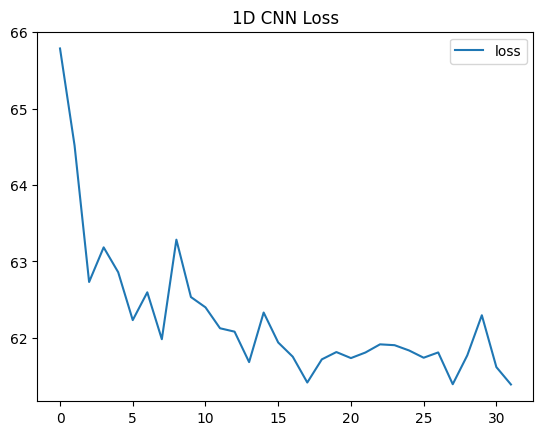

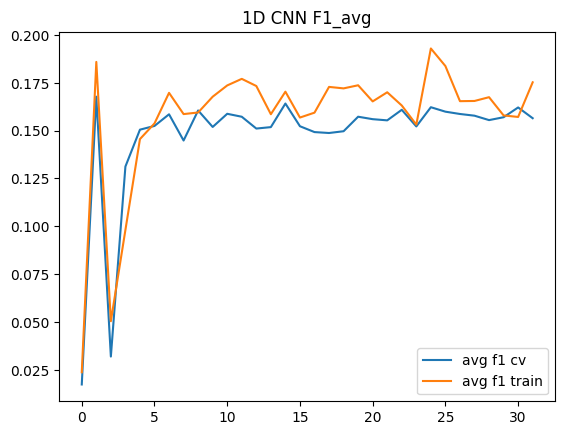

In [156]:
f1_train_list_cpu = [[torch.Tensor.cpu(item) for item in _list] for _list in f1_train_list_list]

loss_list_np = np.array(loss_list_list)
f1_list_np = np.array(f1_list_list)
f1_train_list_np = np.array(f1_train_list_cpu)
print(loss_list_np.shape)
loss_list_avg = np.average(loss_list_np,axis = 0)
f1_list_avg = np.average(f1_list_np,axis = 0)
f1_train_list_avg = np.average(f1_train_list_np,axis = 0)
print(loss_list_np.shape)
import matplotlib.pyplot as plt
plt.plot(loss_list_avg,label = 'loss')
plt.title("1D CNN Loss")
plt.legend()
plt.show()
plt.plot(f1_list_avg,label = 'avg f1 cv')
plt.plot(f1_train_list_avg,label = 'avg f1 train')
plt.legend()
plt.title("1D CNN F1_avg")
plt.show()

expriment #5


In [30]:
from torch.utils.data import Dataset
class Simple1DRandomDataset(Dataset):
    
    def __init__(self, samples: np.ndarray):
        # super().__init__()  # Optional, since Dataset.__init__() is a no-op
        self.samples = samples
    
    # The __getitem__ method is required and should return a single sample based
    # on the provided index.
    def __getitem__(self, index):
        index_2 = None
        while index_2 == index or index_2 == None:
            index_2 = np.random.randint(len(self.samples),size=1)[0]
        first_feature = self.samples[index]
        seconde_feature = self.samples[index_2]
        sample_features = np.append(first_feature,seconde_feature,axis=1)
        return sample_features
    
    def __len__(self):
        return len(self.samples)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.cuda.is_available())
device = torch.device("cuda" )

#split to train / validate
our_dataset = Simple1DRandomDataset(final_data_reshaped)

# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
print(final_data_reshaped.shape)
numTrainSamples = int(len(final_data_reshaped) * TRAIN_SPLIT)
numValSamples = int(len(final_data_reshaped) * VAL_SPLIT)
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
(trainData, valData) = torch.utils.data.random_split(our_dataset,[numTrainSamples, numValSamples],generator=torch.Generator().manual_seed(42))

INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10

#trainData    = torch.utils.data.TensorDataset(torch.tensor(trainData).to(device), torch.tensor(trainData).to(device))
#valData    = torch.utils.data.TensorDataset(torch.tensor(valData).to(device), torch.tensor(valData).to(device))


trainDataLoader = torch.utils.data.DataLoader(trainData, shuffle=True,batch_size=BATCH_SIZE)
valDataLoader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE


True
(1200, 1, 100, 416)


In [43]:
def prepare_data_for_training_5(the_data,seq_ele):
    current_batch_size = len(the_data)
    #the data expected shape [batch,1,seq,features]
    inputs =the_data[:,:,:,:-1]
    if seq_ele < 50 :
        seq_start = 0
        seq_finish = 100
    elif seq_ele > 150 :
        seq_start = 100
        seq_finish = 200 
    else :
        seq_start = seq_ele-50
        seq_finish = seq_ele+50         
    #mel data inputs
    mel_data = torch.zeros([current_batch_size,3,100,60])
    mel_data[:,0,:,:] = inputs[:,0,seq_start:seq_finish,15:75]
    mel_data[:,1,:,:] = inputs[:,0,seq_start:seq_finish,151:211]
    mel_data[:,2,:,:] = inputs[:,0,seq_start:seq_finish,211:271]
    
    #mfcc data inputs
    mfcc_data = torch.zeros([current_batch_size,9,100,20])
    mfcc_data[:,0,:,:] = inputs[:,0,seq_start:seq_finish,75:95]
    mfcc_data[:,1,:,:] = inputs[:,0,seq_start:seq_finish,95:115]
    mfcc_data[:,2,:,:] = inputs[:,0,seq_start:seq_finish,115:135]
    mfcc_data[:,3,:,:] = inputs[:,0,seq_start:seq_finish,271:291]
    mfcc_data[:,4,:,:] = inputs[:,0,seq_start:seq_finish,291:311]
    mfcc_data[:,5,:,:] = inputs[:,0,seq_start:seq_finish,311:331]
    mfcc_data[:,6,:,:] = inputs[:,0,seq_start:seq_finish,331:351]
    mfcc_data[:,7,:,:] = inputs[:,0,seq_start:seq_finish,351:371]
    mfcc_data[:,8,:,:] = inputs[:,0,seq_start:seq_finish,371:391]
    # other features inputs
    feature_input = torch.zeros([current_batch_size,100,55])
    feature_input[:,:,:15] = inputs[:,0,seq_start:seq_finish,:15]
    feature_input[:,:,15:31] = inputs[:,0,seq_start:seq_finish,135:151]
    feature_input[:,:,31:] = inputs[:,0,seq_start:seq_finish,391:]
    # one feature vector 
    vector_input = torch.zeros([current_batch_size,415])
    vector_input[:,:] = inputs[:,0,seq_ele,:]
    # the labels 
    labels = the_data[:,0,seq_ele,-1]
    labels = labels.to(torch.int64)
    targets = torch.nn.functional.one_hot(labels,7).to(torch.float32)
    (mel_data,mfcc_data,feature_input, targets,vector_input) = (mel_data.to(device),mfcc_data.to(device),feature_input.to(device),targets.to(device) ,vector_input.to(device))
    return mel_data,mfcc_data,feature_input,vector_input,targets

In [40]:
def eval_test_5(model) :
    f1_list = np.array([]) 
    acc_list = np.array([]) 
    model.eval()
    for i, data in enumerate(valDataLoader):
            for seq_ele in range(200):
                inputs =data[:,:,:,:-1].to(device)
                mel_data,mfcc_data,feature_input,vector_input,targets = prepare_data_for_training_5(data,seq_ele)
                
                

     
            
                
                outputs = model(mel_data,mfcc_data,feature_input,inputs[:,0,:,:],vector_input,seq_ele)

                _,Maxs_out_i= torch.max(outputs,dim = 1)
                preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
                preds = preds.to(device)
                
                targets = targets.bool()
                preds = preds.bool()

                acc,recall,prec,f1 = eval_fun(preds,targets)
                acc = acc.mean()
                f1 = f1.mean()
                
                acc_list = np.append(acc_list,acc.cpu().numpy())
                f1_list = np.append(f1_list,f1.cpu().numpy())
    return acc_list.mean(),f1_list.mean()

In [45]:
import torch.optim as optim

running_loss = 0.0
f1_train = 0

net = Net()
net.cuda()
#wights =wight_singel_points*np.array([0.25 ,0.1, 0.3, 0.1, 0.1, 0.1 ,0.1])

#wights =np.array([0.25 ,0.1, 0.3, 0.1, 0.1, 0.1 ,0.1])
wights =np.array([0.08116872 ,0.30473066 ,0.05009443, 0.30195998 ,0.30884158, 0.30557651 ,0.30661801])
wights = torch.from_numpy(wights).to(device)

criterion = nn.CrossEntropyLoss(weight=wights)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

loss_list = []
acc_list = []
f1_list = []
f1_train_list = []
for epoch in range(1800):  # loop over the dataset multiple times
    net.train()  
    running_loss = 0.0
    for i, data in enumerate(trainDataLoader):

        inputs =data[:,:,:,:-1].to(device)
        seq_ele = np.random.randint(200,size=1)[0]
        mel_data,mfcc_data,feature_input,vector_input,targets = prepare_data_for_training_5(data,seq_ele)
        (mel_data,mfcc_data,feature_input, targets,inputs,vector_input) = (mel_data.to(device),mfcc_data.to(device),feature_input.to(device), targets.to(device),inputs.to(device),vector_input.to(device))

        
        #train
        optimizer.zero_grad()
        outputs = net(mel_data,mfcc_data,feature_input,inputs[:,0,:,:],vector_input,seq_ele)
        loss = criterion(outputs, targets)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        
        
        # print statistics
        
        _, Maxs_out_i = torch.max(outputs, dim=1)
        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
        preds = preds.to(device)
        
        running_loss += loss.item()
        
        
        _,_,_,f1_train = eval_fun(preds,targets)
    
    if epoch % 100 == 0 :    # print every 100 mini-batches
        f1_train = f1_train.mean()
        acc,f1 = eval_test_5(net)
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f} f1_train : {f1_train:.5f} f1: {f1:.5f} acc:{acc:.5f}')
        loss_list.append(running_loss)
        f1_list.append(f1)
        f1_train_list.append(f1_train)
        acc_list.append(acc)
        #print (f'outputs{nn.Softmax( outputs)}')
        running_loss = 0.0

print('Finished Training')

[1,    15] loss: 3.674 f1_train : 0.00000 f1: 0.01460 acc:0.72991
[101,    15] loss: 2.185 f1_train : 0.11429 f1: 0.32004 acc:0.92810
[201,    15] loss: 1.353 f1_train : 0.28571 f1: 0.41917 acc:0.93312
[301,    15] loss: 1.189 f1_train : 0.28571 f1: 0.49996 acc:0.94033
[401,    15] loss: 1.453 f1_train : 0.19048 f1: 0.58394 acc:0.94567
[501,    15] loss: 0.753 f1_train : 0.14286 f1: 0.56791 acc:0.95098
[601,    15] loss: 0.829 f1_train : 0.38095 f1: 0.61376 acc:0.95741
[701,    15] loss: 1.290 f1_train : 0.05714 f1: 0.61536 acc:0.95224
[801,    15] loss: 0.791 f1_train : 0.28571 f1: 0.64652 acc:0.95842
[901,    15] loss: 1.462 f1_train : 0.23809 f1: 0.61220 acc:0.95561
[1001,    15] loss: 0.776 f1_train : 0.12245 f1: 0.67612 acc:0.95935
[1101,    15] loss: 0.567 f1_train : 0.28571 f1: 0.68866 acc:0.96388
[1201,    15] loss: 0.572 f1_train : 0.14286 f1: 0.70989 acc:0.96786
[1301,    15] loss: 0.605 f1_train : 0.11429 f1: 0.71177 acc:0.96334
[1401,    15] loss: 0.912 f1_train : 0.23809 f

In [46]:
loss_list_list = []
f1_list_list= []
f1_train_list_list= []

In [47]:
loss_list_list.append(loss_list)
f1_list_list.append(f1_list)
f1_train_list_list.append(f1_train_list)

(1, 18)
(1, 18)


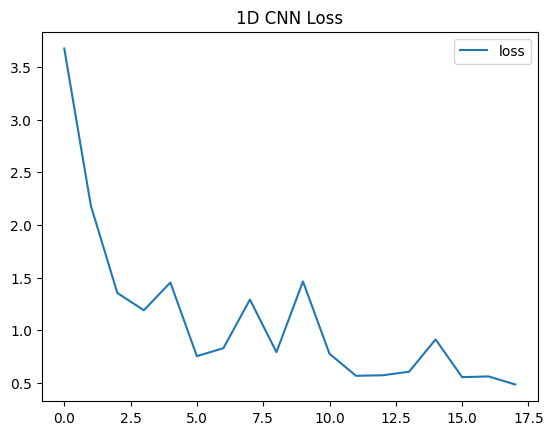

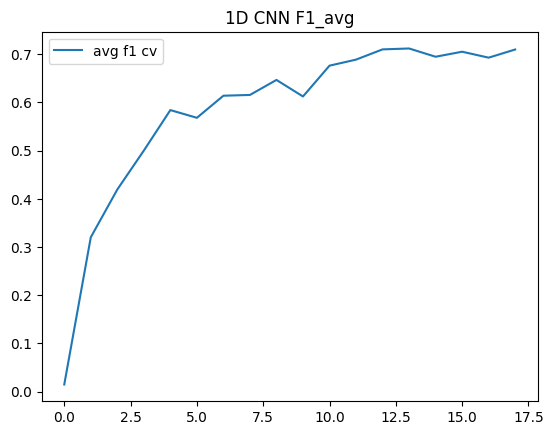

In [49]:
f1_train_list_cpu = [[torch.Tensor.cpu(item) for item in _list] for _list in f1_train_list_list]

loss_list_np = np.array(loss_list_list)
f1_list_np = np.array(f1_list_list)
f1_train_list_np = np.array(f1_train_list_cpu)
print(loss_list_np.shape)
loss_list_avg = np.average(loss_list_np,axis = 0)
f1_list_avg = np.average(f1_list_np,axis = 0)
f1_train_list_avg = np.average(f1_train_list_np,axis = 0)
print(loss_list_np.shape)
import matplotlib.pyplot as plt
plt.plot(loss_list_avg,label = 'loss')
plt.title("1D CNN Loss")
plt.legend()
plt.show()
plt.plot(f1_list_avg,label = 'avg f1 cv')
#plt.plot(f1_train_list_avg,label = 'avg f1 train')
plt.legend()
plt.title("1D CNN F1_avg")
plt.show()

end

In [66]:
def eval_test_with_filter(model,filter_size,is_filterd) :
    net.eval()
    f1_list = np.array([]) 
    acc_list = np.array([]) 
    for i, data in enumerate(valDataLoader):
            # get the inputs; data is a list of [inputs, labels]
            current_batch_size = len(data)
            inputs =data[:,:,:,:-1]
            for seq_ele in range(100):
                mel_data,mfcc_data,feature_input,vector_input,labels = preper_data_for_training(data,seq_ele)
               
                targets = torch.zeros([current_batch_size,7]) 
                preds = torch.zeros([current_batch_size,7]) 
                for i_2,label in enumerate(labels):
                    targets[i_2,label] =1.0
                #targets = targets.type(torch.LongTensor)
                #print(labels)
                
                (mel_data,mfcc_data,feature_input, targets,preds,inputs,vector_input) = (mel_data.to(device),mfcc_data.to(device),feature_input.to(device), targets.to(device),preds.to(device),inputs.to(device),vector_input.to(device))

            # print(inputs.get_device())
            
                outputs = model(mel_data,mfcc_data,feature_input,inputs[:,0,:,:],vector_input,seq_ele)
                # forward + backward + optimize
                # zero the parameter gradients
                
                _,Maxs_out_i= torch.max(outputs,dim = 1)
                Maxs_out_i = Maxs_out_i.int().cpu()
                Maxs_out_i = Maxs_out_i.numpy()
                if (is_filterd):
                    print(len(labels),labels[30:60])
                    filterd_array = apply_filter(Maxs_out_i,filter_size)
                    Maxs_out_i = filterd_array

                for i_2,Max_out_i in enumerate(Maxs_out_i):
                    Max_out_i = int(Max_out_i)
                    preds[i_2,Max_out_i] =1.0
                
                targets = targets.bool()
                preds = preds.bool()
                #targets = targets.cpu().numpy()
                #preds = preds.cpu().numpy()
                #print(targets.dtype)
                # print statistics
                #targets = targets.type('torch.BoolTensor')
                #preds = preds.type('torch.BoolTensor')
                #print(inputs.get_device(),preds.get_device(),targets.get_device())
                acc,recall,prec,f1 = eval_fun(preds,targets)
                #print(preds,targets)

                acc = acc.mean()
                f1 = f1.mean()
                #print("f1__",f1.size())
                acc_list = np.append(acc_list,acc.cpu().numpy())
                f1_list = np.append(f1_list,f1.cpu().numpy())
                del(outputs)
    return acc_list.mean(),f1_list.mean()

In [65]:
def apply_filter(array,filter_size):
    n = len(array)
    filterd_array = np.zeros(n)
    for center in range(filter_size,n-filter_size):
        val,val_count = np.unique(array[center-filter_size:center+filter_size+1], return_counts=True)
        most_repeated_val = val[val_count.argmax()] 
        filterd_array[center] = most_repeated_val
    #fill the first and last element
    for ele in range(0,filter_size):
        filterd_array[ele] = array[ele]
    for ele in range(n-filter_size,n):
        filterd_array[ele] = array[ele]
    print(len(array),array[30:60])
    print(len(filterd_array),filterd_array[30:60])
    return filterd_array

In [177]:
acc,f1 = eval_test(net)
print(f' f1: {f1:.5f} acc:{acc:.5f}')
# acc,f1 = eval_test_with_filter(net,1,True)
# print(f' f1: {f1:.5f} acc:{acc:.5f}')

 f1: 0.73248 acc:0.96799


preds

In [129]:
def data_prepare_for_preds(the_data):
    # data shape (16, 30, 100, 415)
    inputs =the_data[:,:,:,:]
    current_batch_size = the_data.size(1)
    
    #mel data inputs
    mel_data = torch.zeros([16,current_batch_size,3,100,60])
    mel_data[:,:,0,:,:] = inputs[:,:,:,15:75]
    mel_data[:,:,1,:,:] = inputs[:,:,:,151:211]
    mel_data[:,:,2,:,:] = inputs[:,:,:,211:271]
    
    #mfcc data inputs
    mfcc_data = torch.zeros([16,current_batch_size,9,100,20])
    mfcc_data[:,:,0,:,:] = inputs[:,:,:,75:95]
    mfcc_data[:,:,1,:,:] = inputs[:,:,:,95:115]
    mfcc_data[:,:,2,:,:] = inputs[:,:,:,115:135]
    mfcc_data[:,:,3,:,:] = inputs[:,:,:,271:291]
    mfcc_data[:,:,4,:,:] = inputs[:,:,:,291:311]
    mfcc_data[:,:,5,:,:] = inputs[:,:,:,311:331]
    mfcc_data[:,:,6,:,:] = inputs[:,:,:,331:351]
    mfcc_data[:,:,7,:,:] = inputs[:,:,:,351:371]
    mfcc_data[:,:,8,:,:] = inputs[:,:,:,371:391]
    # other features inputs
    feature_input = torch.zeros([16,current_batch_size,100,55])
    feature_input[:,:,:,:15] = inputs[:,:,:,:15]
    feature_input[:,:,:,15:31] = inputs[:,:,:,135:151]
    feature_input[:,:,:,31:] = inputs[:,:,:,391:]
    return mel_data,mfcc_data,feature_input


In [130]:
preds = torch.zeros([16,30,100])
            
net.eval()     
inputs = torch.from_numpy(final_data_reshaped_test.copy())
mel_data,mfcc_data,feature_input = data_prepare_for_preds(inputs)
(mel_data,mfcc_data,feature_input,inputs) = (mel_data.to(device),mfcc_data.to(device),feature_input.to(device),inputs.to(device))
for file in range(16):
    for seq in range (100):
        section_preds = net(mel_data[file,:,:,:,:],mfcc_data[file,:,:,:,:],feature_input[file,:,:,:],inputs[file,:,:,:],inputs[file,:,seq,:],seq)
        _, Maxs_out_i = torch.max(section_preds, dim=1)
        preds[file,:,seq] = Maxs_out_i
preds = preds.int()
preds = preds.numpy()
preds = np.reshape(preds,(16,3000))

In [131]:
print(preds.shape)
for i,file in enumerate(preds):
    if i < 10 :
        nr = '0' + str(i)
    else :
        nr = str(i)
    save_array_to_csv(file, 'test'+str(nr), 'K01635875.csv')
    

(16, 3000)


preds for training

In [132]:
def data_prepare_for_preds(the_data):
    # data shape (16, 30, 100, 415)
    inputs =the_data[:,:,:]
    current_batch_size = the_data.size(0)
    #mel data inputs
    mel_data = torch.zeros([current_batch_size,3,100,60])
    mel_data[:,0,:,:] = inputs[:,:,15:75]
    mel_data[:,1,:,:] = inputs[:,:,151:211]
    mel_data[:,2,:,:] = inputs[:,:,211:271]
    
    #mfcc data inputs
    mfcc_data = torch.zeros([current_batch_size,9,100,20])
    mfcc_data[:,0,:,:] = inputs[:,:,75:95]
    mfcc_data[:,1,:,:] = inputs[:,:,95:115]
    mfcc_data[:,2,:,:] = inputs[:,:,115:135]
    mfcc_data[:,3,:,:] = inputs[:,:,271:291]
    mfcc_data[:,4,:,:] = inputs[:,:,291:311]
    mfcc_data[:,5,:,:] = inputs[:,:,311:331]
    mfcc_data[:,6,:,:] = inputs[:,:,331:351]
    mfcc_data[:,7,:,:] = inputs[:,:,351:371]
    mfcc_data[:,8,:,:] = inputs[:,:,371:391]
    # other features inputs
    feature_input = torch.zeros([current_batch_size,100,55])
    feature_input[:,:,:15] = inputs[:,:,:15]
    feature_input[:,:,15:31] = inputs[:,:,135:151]
    feature_input[:,:,31:] = inputs[:,:,391:]
    return mel_data,mfcc_data,feature_input


In [178]:
preds = np.array([[]])
seq_preds = np.array([[]])
labels = np.array([[]])
net.eval()

#inputs = torch.from_numpy(final_data)
#inputs = torch.unsqueeze(inputs, dim = 0)
#labels = inputs[:,:,-1]
#inputs =inputs[:,:,:-1]
#print(labels.size(),inputs.size())#


for i, data in enumerate(valDataLoader):
    current_batch_size = len(data)
    print(current_batch_size)
    # get the inputs; data is a list of [inputs, labels]
    inputs = data[:,0,:,:-1]
    temp_label = data[:,0,:,-1].int().cpu().numpy()
    if labels.shape[1] == 0:
        labels = temp_label
    else:
        labels = np.append(labels,temp_label,axis=0)

    for seq_ele in range(200):


        mel_data,mfcc_data,feature_input,_,_ = preper_data_for_training_5(data,seq_ele)      
        (mel_data,mfcc_data,feature_input,inputs) = (mel_data.to(device),mfcc_data.to(device),feature_input.to(device),inputs.to(device))

        section_preds = net(mel_data,mfcc_data,feature_input,inputs,inputs[:,seq_ele,:],seq_ele)

        _, Maxs_out_i = torch.max(section_preds, dim=1)
        Maxs_out_i = Maxs_out_i.int().cpu()
        Maxs_out_i = np.array([Maxs_out_i.numpy()]).T
        if seq_preds.shape[1] == 0:
            seq_preds = Maxs_out_i.copy()
        else:
            seq_preds = np.append(seq_preds,Maxs_out_i,axis=1)
    print(Maxs_out_i.shape,preds.shape)  
    if preds.shape[1] == 0:
        preds = seq_preds
    else:
        preds = np.append(preds,seq_preds,axis=0)
    seq_preds = np.array([[]])
            
    print(Maxs_out_i.shape,preds.shape)  

#preds = torch.flatten(preds)
#preds = np.reshape(preds,(16,3000))

64
(64, 1) (1, 0)
(64, 1) (64, 200)
64
(64, 1) (64, 200)
(64, 1) (128, 200)
64
(64, 1) (128, 200)
(64, 1) (192, 200)
64
(64, 1) (192, 200)
(64, 1) (256, 200)
44
(44, 1) (256, 200)
(44, 1) (300, 200)


In [179]:
print(preds.shape)
print(labels.shape)
for i,seq in enumerate(preds):
    save_array_to_csv(seq, 'test'+str(i), 'preds_eval_data.csv')
for i,seq in enumerate(labels):
    save_array_to_csv(seq, 'test'+str(i), 'true_eval_data.csv')

(300, 200)
(300, 200)


In [85]:
torch.cuda.empty_cache()